## Activity 6.10

### Clustering Analysis of US Hospitals

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

### Data importation and cleaning
1. Identify the data quality problems in this dataset such as unusual data types, missing values, etc., and explain how to fix them.

In [2]:
hospitals = pd.read_csv('data/usa_hospital_beds-2.csv')

In [3]:
hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626 entries, 0 to 6625
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   X                                6609 non-null   float64
 1   Y                                6609 non-null   float64
 2   ID                               6626 non-null   int64  
 3   HOSPITAL_NAME                    6626 non-null   object 
 4   HOSPITAL_TYPE                    6626 non-null   object 
 5   ADDRESS                          6626 non-null   object 
 6   CITY                             6626 non-null   object 
 7   STATE                            6626 non-null   object 
 8   ZIP_CODE                         6626 non-null   int64  
 9   COUNTY_NAME                      6602 non-null   object 
 10  STATE_NAME                       6602 non-null   object 
 11  NUM_LICENSED_BEDS                6403 non-null   float64
 12  NUM_STAFFED_BEDS    

The data appears to have been imported in the correct format for each variable.

In [4]:
# Is there any difference between these variables?

(hospitals.NUM_ICU_BEDS == hospitals.ADULT_ICU_BEDS).value_counts()

True    6626
dtype: int64

There does not seem to be any difference between reporded total ICU beds and pooled specialty ICU beds in this dataset. Therefore, we can get rid of one of these redundant variables.

In [5]:
hospitals.drop('ADULT_ICU_BEDS', axis=1, inplace=True)

Next we can examine the data for missing and nonsensical values.

In [6]:
hospitals.isna().sum()

X                                   17
Y                                   17
ID                                   0
HOSPITAL_NAME                        0
HOSPITAL_TYPE                        0
ADDRESS                              0
CITY                                 0
STATE                                0
ZIP_CODE                             0
COUNTY_NAME                         24
STATE_NAME                          24
NUM_LICENSED_BEDS                  223
NUM_STAFFED_BEDS                   298
NUM_ICU_BEDS                         0
BED_UTILIZATION                    709
Potential_Increase_In_Bed_Capac      0
AVG_VENTILATOR_USAGE                59
dtype: int64

In [7]:
hospitals.describe().T

,count,mean,std,min,25%,50%,75%,max
X,6609.0,-92.492790,16.123889,-170.685773,-98.216599,-90.094404,-81.943245,145.72417
Y,6609.0,37.557421,5.690748,-14.290190,33.610770,38.282481,41.448538,71.29890
ID,6626.0,3313.500000,1912.905774,1.000000,1657.250000,3313.500000,4969.750000,6626.00000
ZIP_CODE,6626.0,53730.065047,27325.426578,603.000000,32210.250000,55302.500000,76378.500000,99929.00000
NUM_LICENSED_BEDS,6403.0,148.087303,182.684947,1.000000,25.000000,75.000000,197.000000,2059.00000
NUM_STAFFED_BEDS,6328.0,127.668458,160.116186,1.000000,25.000000,65.000000,166.000000,2753.00000
NUM_ICU_BEDS,6626.0,14.019771,22.457818,0.000000,3.000000,6.000000,16.000000,310.00000
BED_UTILIZATION,5917.0,0.491855,0.235353,0.000721,0.300923,0.497300,0.675295,1.00000
Potential_Increase_In_Bed_Capac,6626.0,21.176728,74.012221,-1389.000000,0.000000,0.000000,23.000000,1446.00000
AVG_VENTILATOR_USAGE,6567.0,3.550023,5.464410,0.000000,0.000000,2.000000,4.000000,61.00000


There are a significant number of missing values for bed utilisation, numbers of beds and average ventilator use. There are clearly nonsensical values in potential increase in bed capacity.
<br>
The nonsensical potential increase numbers may be as a result of variably missing staffed and licensed bed numbers, let us exclude hospitals which are missing this crucial data and then re-examine.

In [8]:
hospitals.dropna(subset=['NUM_LICENSED_BEDS', 'NUM_STAFFED_BEDS'], axis=0, inplace=True)

In [9]:
hospitals.isna().sum()

X                                   14
Y                                   14
ID                                   0
HOSPITAL_NAME                        0
HOSPITAL_TYPE                        0
ADDRESS                              0
CITY                                 0
STATE                                0
ZIP_CODE                             0
COUNTY_NAME                         21
STATE_NAME                          21
NUM_LICENSED_BEDS                    0
NUM_STAFFED_BEDS                     0
NUM_ICU_BEDS                         0
BED_UTILIZATION                    412
Potential_Increase_In_Bed_Capac      0
AVG_VENTILATOR_USAGE                 6
dtype: int64

In [10]:
hospitals.describe().T

,count,mean,std,min,25%,50%,75%,max
X,6314.0,-92.542705,16.128744,-170.685773,-98.338522,-90.092766,-82.096222,145.72417
Y,6314.0,37.585339,5.674687,-14.290190,33.654351,38.285315,41.460538,71.29890
ID,6328.0,3230.820796,1865.280885,1.000000,1616.750000,3228.500000,4838.250000,6611.00000
ZIP_CODE,6328.0,53839.517225,27135.983052,603.000000,32489.750000,55101.000000,76235.500000,99929.00000
NUM_LICENSED_BEDS,6328.0,148.951802,182.822112,1.000000,25.000000,76.000000,198.000000,2059.00000
NUM_STAFFED_BEDS,6328.0,127.668458,160.116186,1.000000,25.000000,65.000000,166.000000,2753.00000
NUM_ICU_BEDS,6328.0,14.192004,22.502739,0.000000,3.000000,6.000000,16.000000,310.00000
BED_UTILIZATION,5916.0,0.491888,0.235358,0.000721,0.300929,0.497316,0.675346,1.00000
Potential_Increase_In_Bed_Capac,6328.0,21.283344,73.510578,-1389.000000,0.000000,0.000000,24.000000,1446.00000
AVG_VENTILATOR_USAGE,6322.0,3.663081,5.531065,0.000000,0.000000,2.000000,4.000000,61.00000


We've successfully eliminated most of our missing data (barring BED_UTILIZATION), but the very negative and very large potential increase values persist.
<br>
Let's examine them more closely to decide if they are truly nonsense.

In [11]:
#Examine the hospital with most negative

hospitals.loc[hospitals.Potential_Increase_In_Bed_Capac.idxmin()]

X                                                                         -81.369541
Y                                                                           28.57447
ID                                                                               804
HOSPITAL_NAME                      AdventHealth Orlando (FKA Florida Hospital Orl...
HOSPITAL_TYPE                                         Short Term Acute Care Hospital
ADDRESS                                                             601 E Rollins St
CITY                                                                         Orlando
STATE                                                                             FL
ZIP_CODE                                                                       32803
COUNTY_NAME                                                                   Orange
STATE_NAME                                                                   Florida
NUM_LICENSED_BEDS                                                

In [12]:
# Examine hospital with largest potential increase

hospitals.loc[hospitals.Potential_Increase_In_Bed_Capac.idxmax()]

X                                                                         -93.237108
Y                                                                          44.967806
ID                                                                              5654
HOSPITAL_NAME                      M Health Fairview University of Minnesota Maso...
HOSPITAL_TYPE                                                     Childrens Hospital
ADDRESS                                                           2450 Riverside Ave
CITY                                                                     Minneapolis
STATE                                                                             MN
ZIP_CODE                                                                       55454
COUNTY_NAME                                                                 Hennepin
STATE_NAME                                                                 Minnesota
NUM_LICENSED_BEDS                                                

Ultimately, these values seem to be correct. Both the largest and smallest potential increase values occurr in very large hospitals which are operating markedly over or under capacity. We will include these hospitals for now, but an argument could be made for excluding them as outliers.
<br>
<br>
Finally, we need to deal with the remaining missing values in the BED_UTILIZATION variable. Excluding 412 would result in a significant loss of data. To avoid this, we can impute these missing values with median of available data. Another option here (as there may be a relationship between other data and bed utilisation) would be to use iterative regressive imputation (via sklearn IterativeImputer).
<br><br>
If any other variables continue to be missing, we will exclude following this.

In [13]:
hospitals.BED_UTILIZATION.fillna(hospitals.BED_UTILIZATION.median(), inplace=True)

In [14]:
hospitals.isna().sum()

X                                  14
Y                                  14
ID                                  0
HOSPITAL_NAME                       0
HOSPITAL_TYPE                       0
ADDRESS                             0
CITY                                0
STATE                               0
ZIP_CODE                            0
COUNTY_NAME                        21
STATE_NAME                         21
NUM_LICENSED_BEDS                   0
NUM_STAFFED_BEDS                    0
NUM_ICU_BEDS                        0
BED_UTILIZATION                     0
Potential_Increase_In_Bed_Capac     0
AVG_VENTILATOR_USAGE                6
dtype: int64

In [15]:
hospitals.dropna(subset=['AVG_VENTILATOR_USAGE'], axis=0, inplace=True)
hospitals.reset_index(inplace=True)

In [16]:
hospitals.isna().sum()

index                               0
X                                  14
Y                                  14
ID                                  0
HOSPITAL_NAME                       0
HOSPITAL_TYPE                       0
ADDRESS                             0
CITY                                0
STATE                               0
ZIP_CODE                            0
COUNTY_NAME                        20
STATE_NAME                         20
NUM_LICENSED_BEDS                   0
NUM_STAFFED_BEDS                    0
NUM_ICU_BEDS                        0
BED_UTILIZATION                     0
Potential_Increase_In_Bed_Capac     0
AVG_VENTILATOR_USAGE                0
dtype: int64

### Clustering Model 1 - Beds and Ventilator Capacity
Build a clustering model to profile the hospitals based on the beds and ventilators'

#### Pre-processing for clustering

We will base out clustering model on the following variables:
- NUM_LICENSED_BEDS
    - This will provide an overview of the total beds an hospital has
- Potential_Increase_In_Bed_Capac
    - This difference between staffed and lisenced beds will provide insight into the potential stretch capcity in each hospital
    - Given that is calculated using the NUM_STAFFED_BEDS variable, it is now reduntant and we no longer need to include it in out clustering model
- NUM_ICU_BEDS
    - Unfortunately, not split into types of ICU bed (ventialted, dialysis, level 1/2/3 etc)
- BED_UTILIZATION
    - Provides an insight into the expected number of free beds at baseline
- AVG_VENTILATOR_USAGE
    - Provides an insight into the number of ventilated patients cared. Inferences can be made about baseline skill in managing ventilated patients, number of skilled staff and equipment already available
    
<br>

We have no categorical variables to examine in this model, so we will use the k-means algorithm.

<br>
K-means requires some data pre-processing as it is sensitive to skewed distributions and varying scale and mean between variables. Initially, we will visually examine the chosen variables for skewness and attempt to unskew them with log transformation for positive variables or cube root transofmration for variables with meaningful 0 or negative values. Subsequently, we will use the sklearn StandardScaler the center the variables and ensure they are equally scaled.

In [17]:
clus_vars = ['NUM_LICENSED_BEDS', 'Potential_Increase_In_Bed_Capac', 'NUM_ICU_BEDS', 'BED_UTILIZATION', 'AVG_VENTILATOR_USAGE']

array([[<AxesSubplot:title={'center':'NUM_LICENSED_BEDS'}>,
        <AxesSubplot:title={'center':'Potential_Increase_In_Bed_Capac'}>],
       [<AxesSubplot:title={'center':'NUM_ICU_BEDS'}>,
        <AxesSubplot:title={'center':'BED_UTILIZATION'}>],
       [<AxesSubplot:title={'center':'AVG_VENTILATOR_USAGE'}>,
        <AxesSubplot:>]], dtype=object)

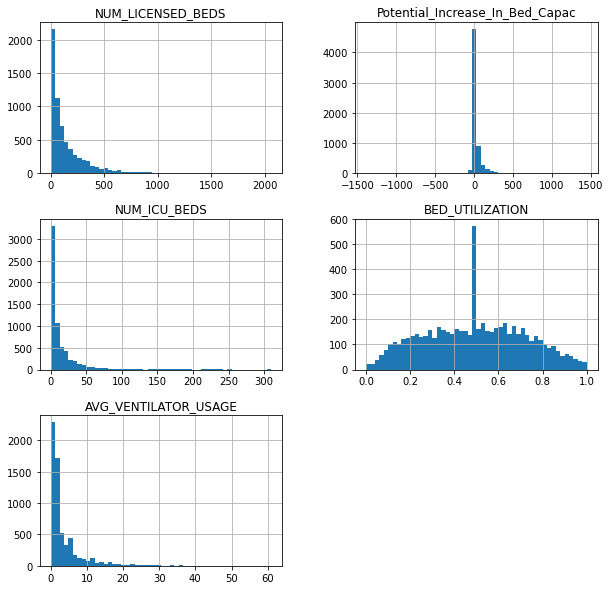

In [18]:
to_cluster = hospitals[clus_vars]

to_cluster.hist(figsize=(10,10), bins = 50)

NUM_LICENSED_BEDS, NUM_ICU_BEDS and AVG_VENTILATOR_USAGE are all significantly left skewed. We can check the the transformations applied are beneficial below:

<AxesSubplot:>

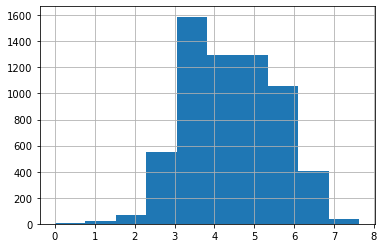

In [19]:
np.log(to_cluster.NUM_LICENSED_BEDS).hist()

<AxesSubplot:>

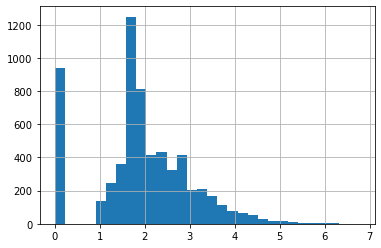

In [20]:
np.cbrt(to_cluster.NUM_ICU_BEDS).hist(bins=30)

<AxesSubplot:>

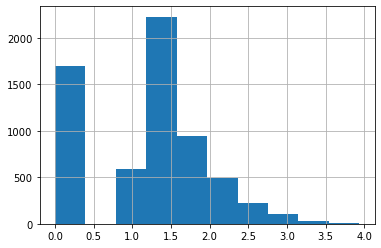

In [21]:
np.cbrt(to_cluster.AVG_VENTILATOR_USAGE).hist(bins=10)

In [22]:
to_cluster.NUM_LICENSED_BEDS = np.log(to_cluster.NUM_LICENSED_BEDS)
to_cluster.NUM_ICU_BEDS = np.cbrt(to_cluster.NUM_ICU_BEDS)
to_cluster.AVG_VENTILATOR_USAGE = np.cbrt(to_cluster.AVG_VENTILATOR_USAGE)

C:\Users\swheb\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
# To matrix
X = to_cluster.to_numpy()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create a seperaate scaled dataframe for later plotting
to_cluster_scaled = pd.DataFrame(X, columns=to_cluster.columns)

In [24]:
# Sanity check for no missing values
np.isnan(X).any()

False

#### Determining optimal K

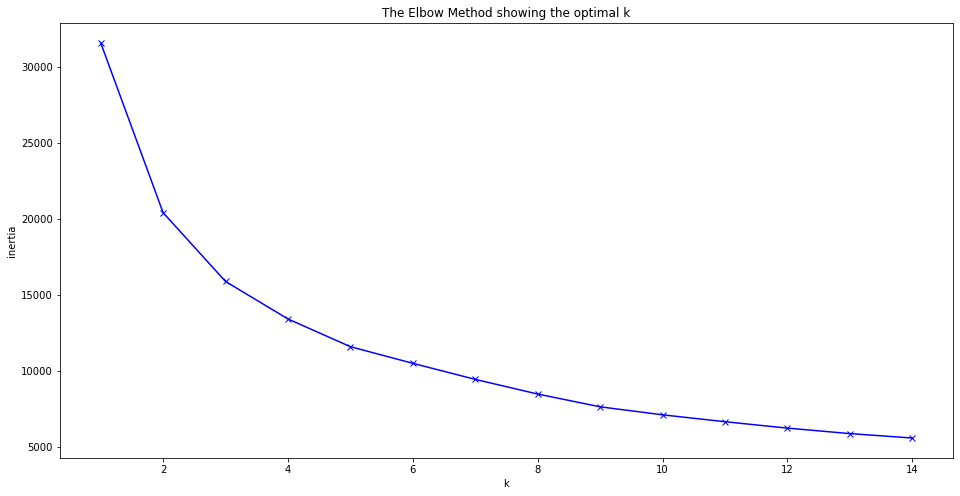

In [25]:
inertia = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

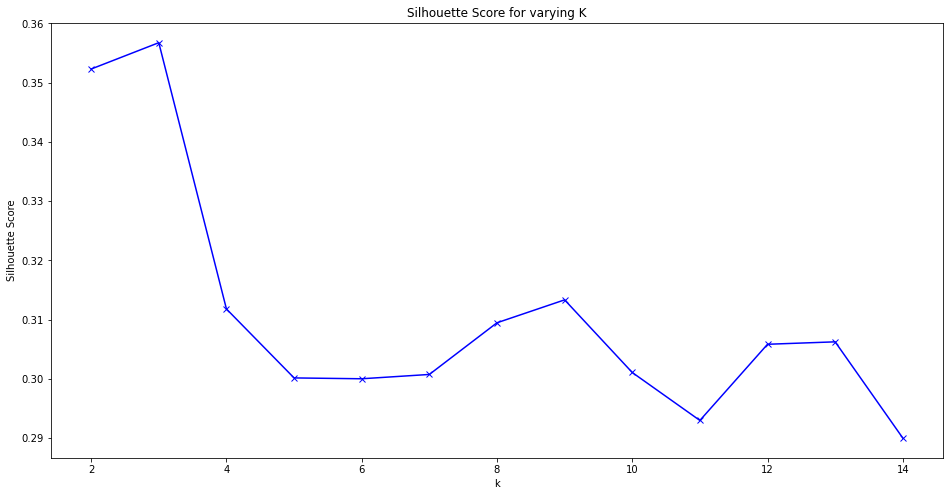

In [26]:
silscore = []
K = range(2,15)

for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(X)
    silscore.append(silhouette_score(X, kmeanModel.predict(X)))
    
plt.figure(figsize=(16,8))
plt.plot(K, silscore, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for varying K')
plt.show()

Examining the plots above for intra-cluster distance and Silhouette score, 3 clusters appears to be the optimal number for K. It is approximately at the elbow of the plot of intertia and has the highest Silhouette score.
<br>
<br>
We will now create the final model with 3 clusters:

In [27]:
model = KMeans(n_clusters=3, random_state=42, init='k-means++')
model.fit(X)

hospitals['bed_vent_clusters'] = model.predict(X)
to_cluster_scaled['bed_vent_clusters'] = model.predict(X)

print("Cluster membership:")
print(hospitals.bed_vent_clusters.value_counts())

Cluster membership:
1    2973
0    2218
2    1131
Name: bed_vent_clusters, dtype: int64


visualise the clusters using ‘pairplot’ and interpret the visualisation

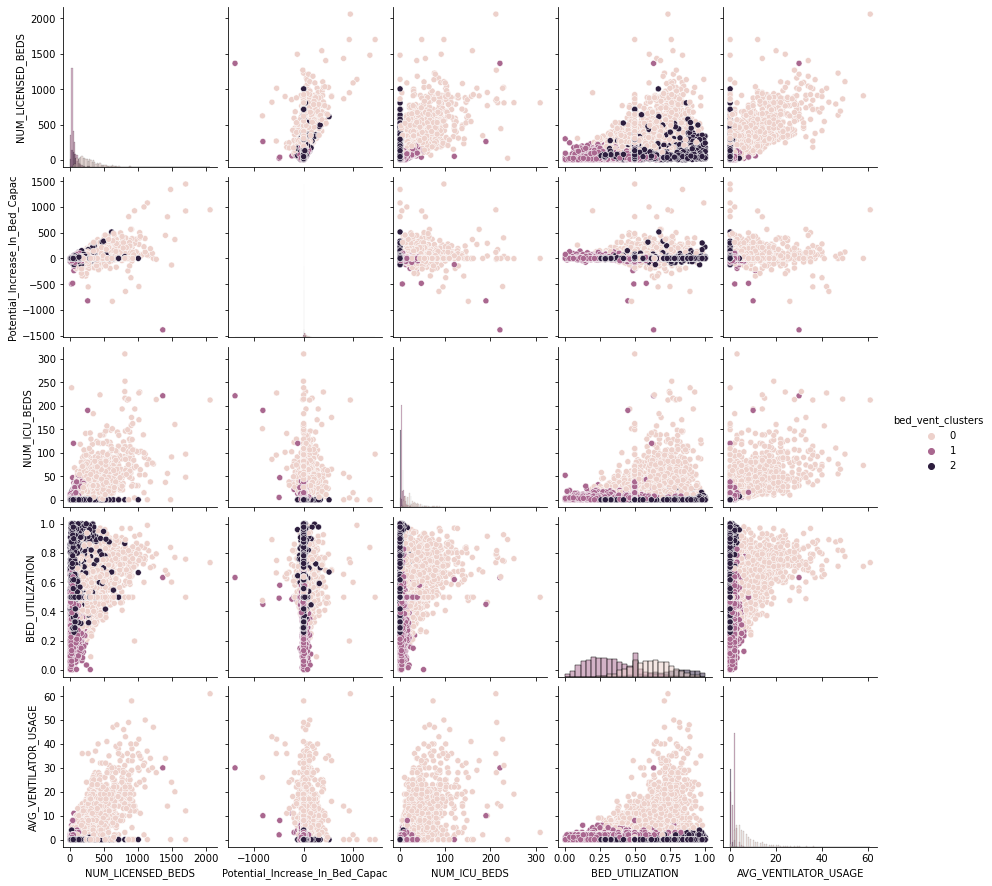

In [28]:
#fig, ax = plt.subplots(figsize=(15,15))

g = sns.pairplot(data=hospitals, vars=clus_vars, hue='bed_vent_clusters', diag_kind='hist')

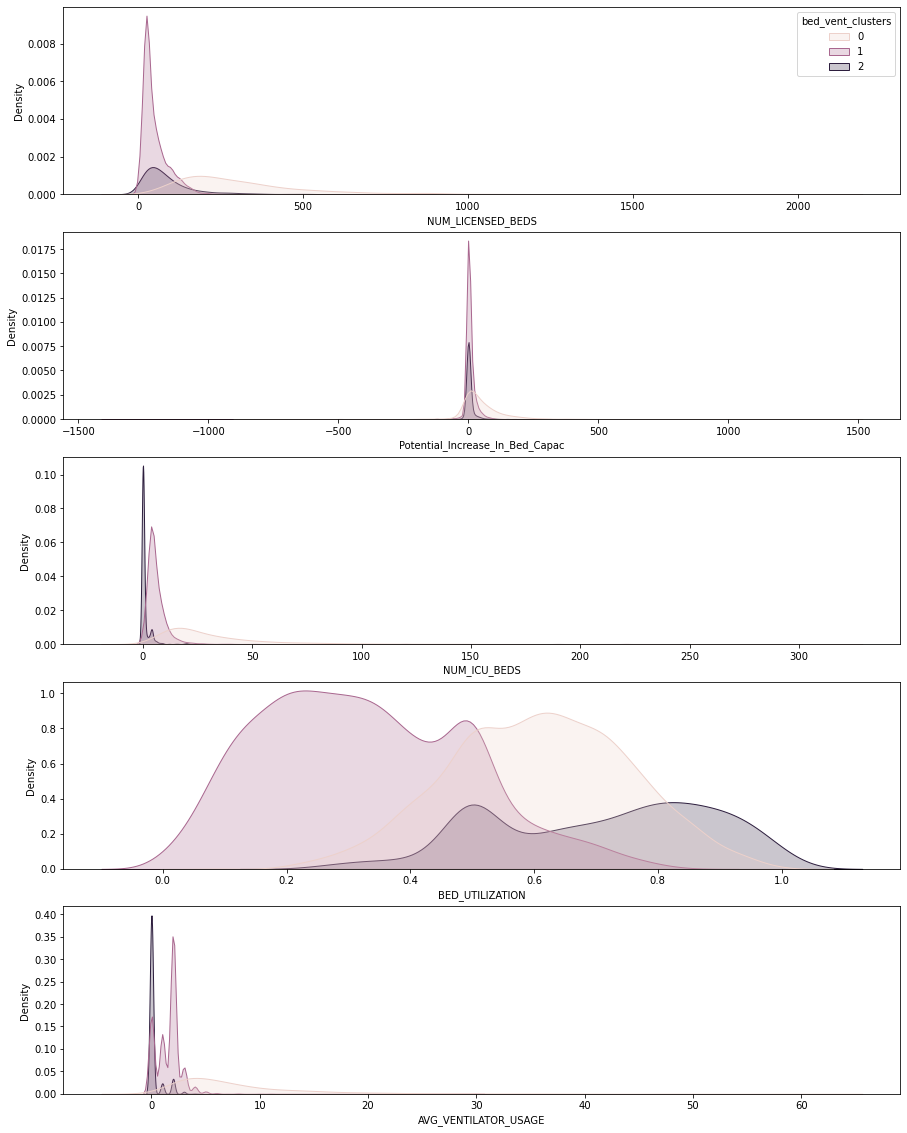

In [29]:
fig, ax = plt.subplots(nrows=len(clus_vars), figsize=(15,20))

for i in range(len(clus_vars)):
    if i == 0:
        legend = True
    else:
        legend = False
    sns.kdeplot(data=hospitals, x=clus_vars[i], hue='bed_vent_clusters', shade=True,
                 ax = ax[i], legend=legend)
    
leg = ax[0].get_legend()

#### Interpretation of Clustering Model 1 (Beds and Ventilator Usage)

**Pairplot**<br>
As the number of licensed beds increased - the number of ICU beds, bed utilisation, ventilator usage and potential increase in beds also increased. Average ventilator use also increased with the number of ICU beds, as expected. Most hospitals and no or limited ability to increase their bed capacity, although those with a greater number of overall beds had greater poential increases in capacity. 
<br>
<br>
**Clusters**<br>
*Cluster 0 - Large Hospitals*
- Large hospitals with the greatest number of total beds, intensive care beds and ventilator usage
- Moderate to high bed utilisation with generally better potential to increase bed capacity
<br>
*Cluster 1 - Smaller Hospitals with Intensive Care Units*
- Lower number of total beds, has intensive care beds with consistent ventilator usage
- Lower overall bed utilisation than other clusters, but with limited capacity to increase beds
<br>
*Cluster 2 - Smaller Hospitals with Limited Intensive Care*
- Lower number of total beds, low to no intensive care beds and ventilator usage
- Higher overall bed utilisation with limited capacity to increase beds

### Clustering Model 2 - Service Provision + Beds + Ventilators

We can now create a clustering model incorporating the categorical variable of HOSPITAL_TYPE. The best way to do this is utilising the KPrototypes algorithm, which uses a combination of KModes and KMeans. <br>
We can continue to use the transformed and scaled numberic data from earlier.

In [30]:
hospital_map = {'Short Term Acute Care Hospital': 1, 'Critical Access Hospital': 2, 'Psychiatric Hospital': 3,
                'Long Term Acute Care Hospital': 4, 'Rehabilitation Hospital': 5, 'Childrens Hospital': 6,
                'VA Hospital': 7, 'Department of Defense Hospital': 8, 
                'Religious Non-Medical Health Care Institution': 9}

hospitals['numeric_types'] = hospitals['HOSPITAL_TYPE'].map(hospital_map)

In [31]:
# Add the hospital types to our already transformed and scaled variables from the previous model

to_cluster_scaled['numeric_types'] = hospitals['numeric_types']

# Add to the list of clustering variables
clus_vars.append('numeric_types')

# Create an array for KProto clustering 
X = to_cluster_scaled[clus_vars].to_numpy()

In [32]:
# Split into cat and con arrays
X_cat = X[:,5].reshape(-1, 1)
X_con = X[:,:5]

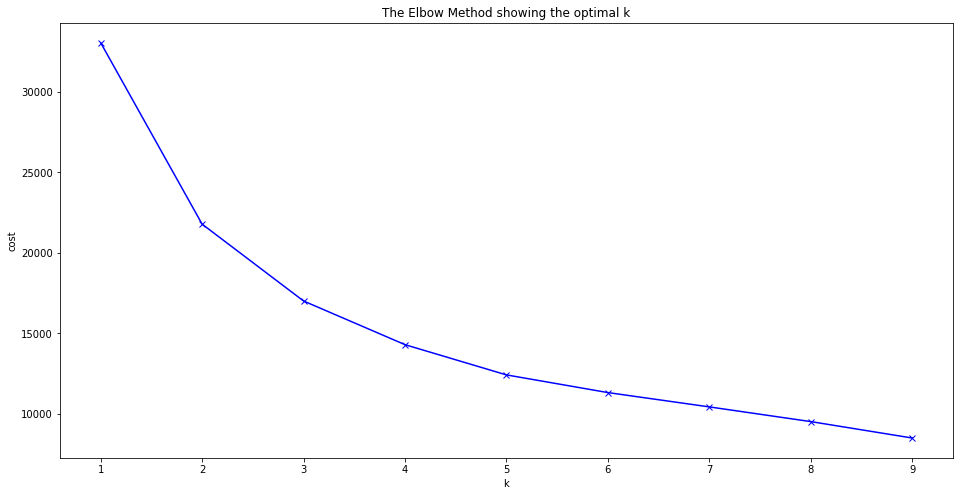

In [33]:
cost = []
K = range(1,10)
for k in K:
    kproto_model = KPrototypes(n_clusters=k, random_state=42, n_jobs=-1)
    kproto_model.fit(X, categorical=[5])
    cost.append(kproto_model.cost_)
    
plt.figure(figsize=(16,8))
plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('cost')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
def kproto_silscore(full_data, num_data, cat_data, cat_columns, k):
    silscore = []
    
    for i in range(2,k):
        mod = KPrototypes(n_clusters=i, random_state=42, n_jobs=-1)
        silScoreNums = silhouette_score(num_data, mod.fit_predict(full_data, categorical=cat_columns), metric='euclidean')
        silScoreCats = silhouette_score(cat_data, mod.fit_predict(full_data, categorical=cat_columns), metric='hamming')
        silScore = (silScoreNums + silScoreCats) / 2
        silscore.append(silScore)
        print(f"for K = {i}, numeric SilScore is {silScoreNums}, categorical SilScore is {silScoreCats} with an average SilScore of {silScore}.")
        
    plt.figure(figsize=(16,8))
    plt.plot(range(2,k), silscore, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for varying K')
    plt.show()

for K = 2, numeric SilScore is 0.3470446669448859, categorical SilScore is 0.25509935501073694 with an average SilScore of 0.30107201097781144.
for K = 3, numeric SilScore is 0.356669691932094, categorical SilScore is 0.2252437028630431 with an average SilScore of 0.2909566973975686.
for K = 4, numeric SilScore is 0.30117022633598745, categorical SilScore is 0.004085167473051912 with an average SilScore of 0.1526276969045197.
for K = 5, numeric SilScore is 0.2956652575340906, categorical SilScore is -0.07686072511761549 with an average SilScore of 0.10940226620823756.


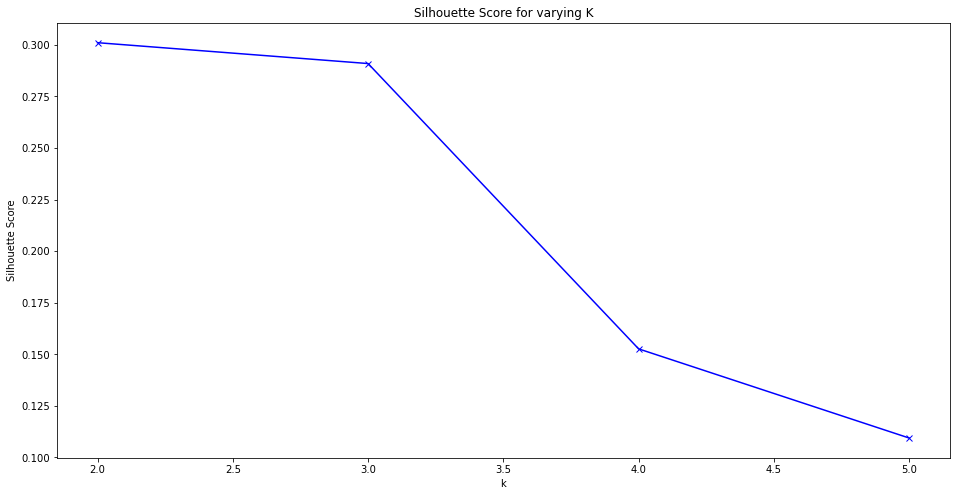

In [35]:
kproto_silscore(X, X_con, X_cat, cat_columns=[5], k=6)

The optimal number for k still appears to be 3 by the elbow method and Silhouette score.

In [36]:
model = KPrototypes(n_clusters=3, random_state=42, n_jobs=-1)
model.fit(X, categorical=[5])

hospitals['type_bed_vent_clusters'] = model.predict(X, categorical=[5])
to_cluster_scaled['type_bed_vent_clusters'] = model.predict(X, categorical=[5])

print("Cluster membership:")
print(hospitals.type_bed_vent_clusters.value_counts())

Cluster membership:
2    2975
0    2219
1    1128
Name: type_bed_vent_clusters, dtype: int64


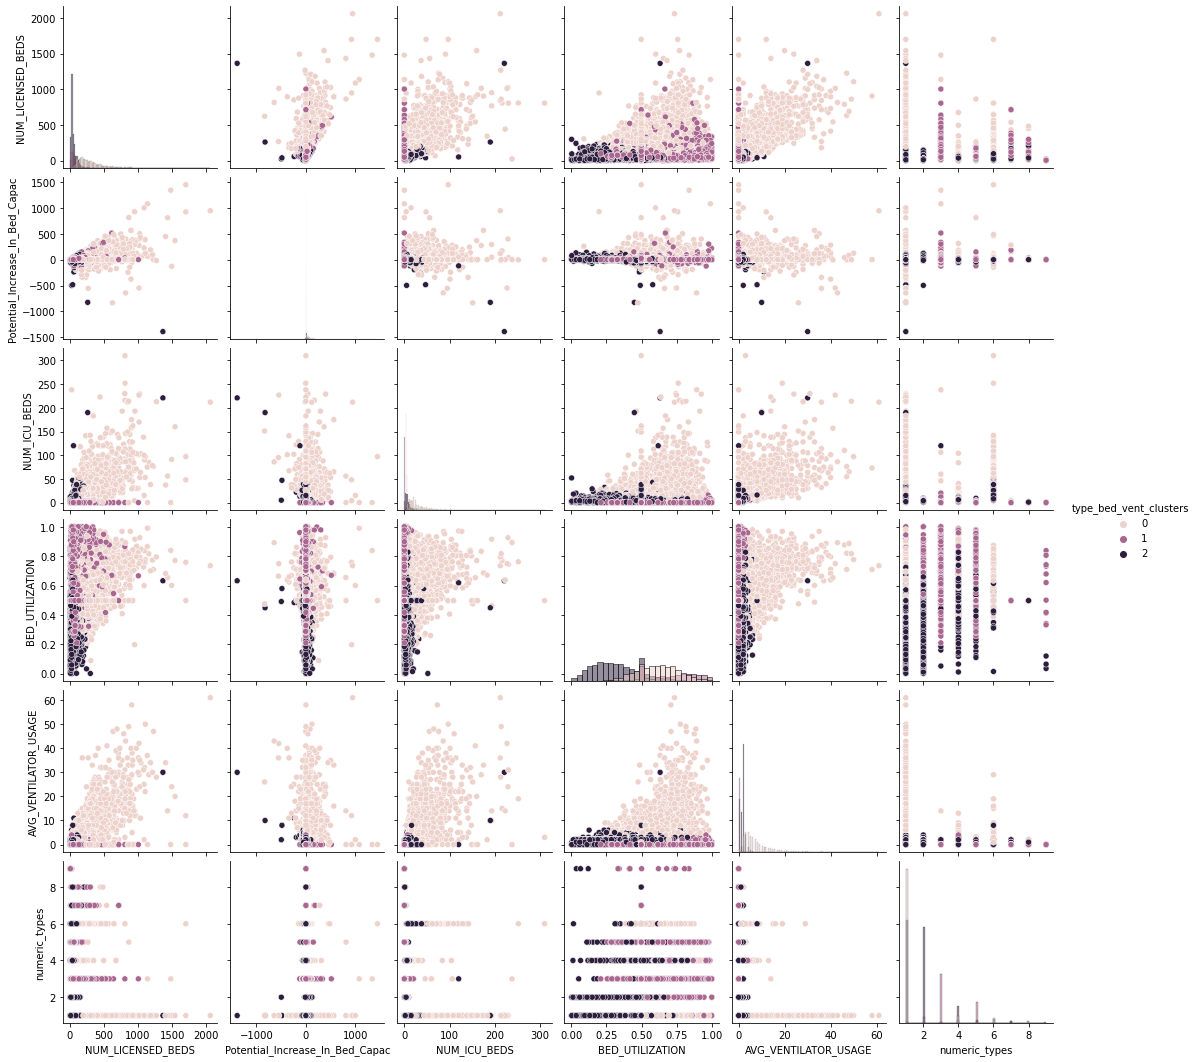

In [37]:
g = sns.pairplot(data=hospitals, vars=clus_vars, hue='type_bed_vent_clusters', diag_kind='hist')

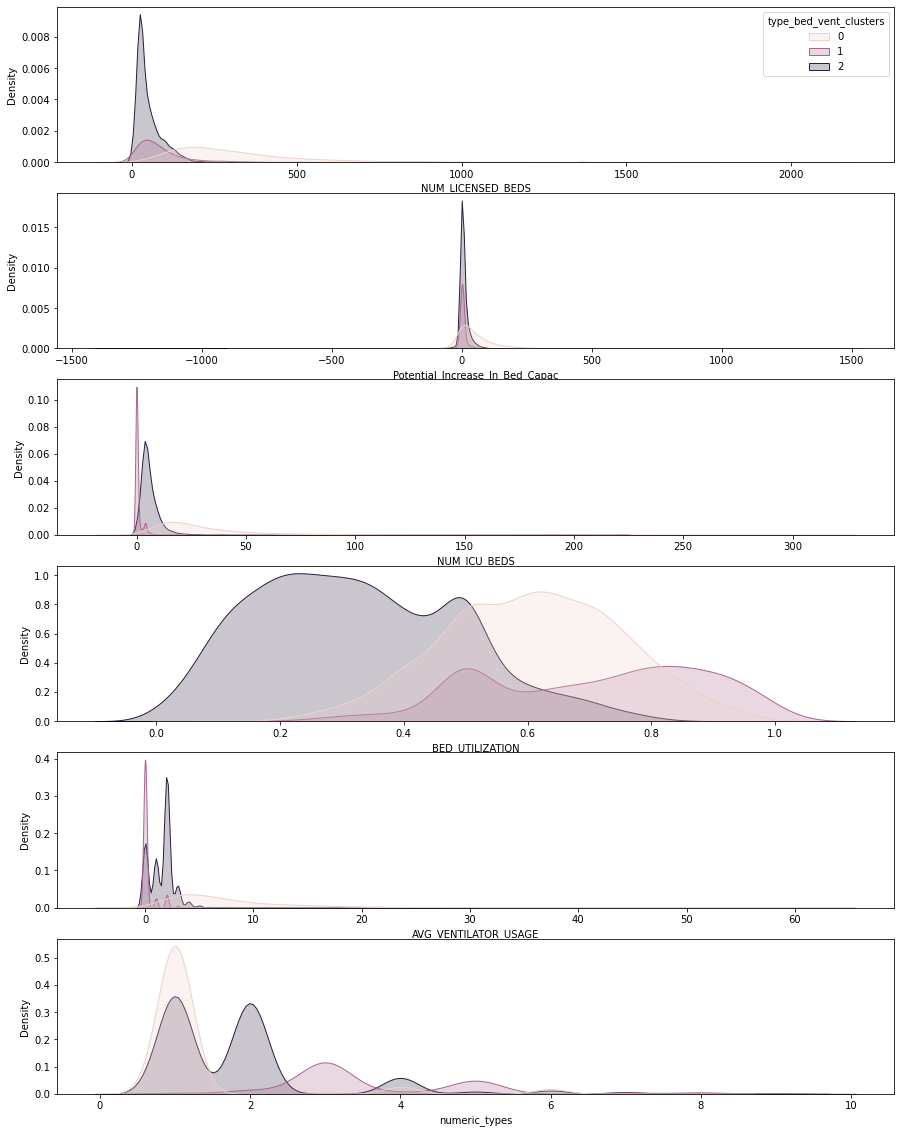

In [38]:
fig, ax = plt.subplots(nrows=len(clus_vars), figsize=(15,20))

for i in range(len(clus_vars)):
    if i == 0:
        legend = True
    else:
        legend = False
    sns.kdeplot(data=hospitals, x=clus_vars[i], hue='type_bed_vent_clusters', shade=True,
                 ax = ax[i], legend=legend)
    
leg = ax[0].get_legend()

#### Interpretation of Clustering Model 1 (Beds and Ventilator Usage)

**Pairplot**<br>
The assessment of the continuous numeric variables remains unchanged in the pairplot of this model.<br>
Examining the impact of hospital type:
- Short Term Acute Care Hospitals had the greatest number of overall beds and ICU beds with the greatest average ventilator usage
- Childrens hospitals also had significan numbers of ICU beds and ventilator usage
- While the remaining hospital types varied in size, the overall number of ICU beds and ventilator usage was low
<br>
<br>
**Clusters**<br>
*Cluster 0 - Large Hospitals*
- Large hospitals with the greatest number of total beds, intensive care beds and ventilator usage
- Moderate to high bed utilisation with generally better potential to increase bed capacity
- Predominantly SHort Term Acute Care Hospitals
<br>
*Cluster 1 - Smaller Hospitals with Limited Intensive Care*
- Lower number of total beds, low to no intensive care beds and ventilator usage
- Higher overall bed utilisation with limited capacity to increase beds
- A mixture of hospitals including Psychiatric Hospitals and Rehabilitation Hospitals
<br>
*Cluster 2 - Smaller Hospitals with Intensive Care Units*
- Lower number of total beds, has intensive care beds with consistent ventilator usage
- Lower overall bed utilisation than other clusters, but with limited capacity to increase beds.
- Diverse range of hospitals including SHort Term, Critical Access, Long Term and Children's Hospitals